# Predicting babyweight using BigQuery ML

This notebook illustrates:
<ol>
<li> Machine Learning using BigQuery
<li> Jupyter Magic for BigQuery in Cloud Datalab
</ol>

Please see [this notebook](1_explore.ipynb) for more context on this problem and how the features were chosen.

In [8]:
# change these to try this notebook out
PROJECT = 'qwiklabs-gcp-03-37b4edc3a6bb'
REGION = 'us-central1'

In [9]:
import os
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [10]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Exploring the Data

Here, we will be taking natality data and training on features to predict the birth weight.

The CDC's Natality data has details on US births from 1969 to 2008 and is available in BigQuery as a public data set. More details: https://bigquery.cloud.google.com/table/publicdata:samples.natality?tab=details

Lets start by looking at the data since 2000 with useful values > 0!

In [11]:
%%bigquery
SELECT
    *
FROM
  publicdata.samples.natality
WHERE
  year > 2000
  AND gestation_weeks > 0
  AND mother_age > 0
  AND plurality > 0
  AND weight_pounds > 0
LIMIT 10

,source_year,year,month,day,wday,state,is_male,child_race,weight_pounds,plurality,...,alcohol_use,drinks_per_week,weight_gain_pounds,born_alive_alive,born_alive_dead,born_dead,ever_born,father_race,father_age,record_weight
0,2001,2001,5,NaN,3,FL,True,9,6.686620,1,...,False,NaN,40,0,0,0,1,9,99,1
1,2001,2001,8,NaN,2,KS,True,9,9.360828,1,...,False,NaN,36,0,0,1,1,1,34,1
2,2001,2001,9,NaN,2,KY,False,9,8.437091,1,...,False,NaN,40,0,0,0,1,1,30,1
3,2002,2002,10,NaN,2,AL,False,9,6.124442,1,...,False,NaN,27,0,0,0,1,1,26,1
4,2002,2002,5,NaN,5,AZ,False,9,7.125340,1,...,False,NaN,39,3,0,1,4,1,26,1
5,2001,2001,10,NaN,3,CA,False,9,6.944561,1,...,None,NaN,99,0,0,0,1,1,27,1
6,2001,2001,8,NaN,2,MS,True,9,6.999677,1,...,False,NaN,32,2,0,2,3,1,25,1
7,2001,2001,2,NaN,6,NY,True,9,9.374055,1,...,False,NaN,48,1,0,0,2,1,32,1
8,2001,2001,11,NaN,3,OR,True,9,8.373157,1,...,False,NaN,25,1,0,1,2,1,40,1
9,2001,2001,7,NaN,2,TX,False,9,7.187070,1,...,False,NaN,24,0,0,0,1,9,99,1


## Define Features

Looking over the data set, there are a few columns of interest that could be leveraged into features for a reasonable prediction of approximate birth weight.

Further, some feature engineering may be accomplished with the BigQuery `CAST` function -- in BQML, all strings are considered categorical features and all numeric types are considered continuous ones.

The hashmonth is added so that we can repeatably split the data without leakage -- we want all babies that share a birthday to be either in training set or in test set and not spread between them (otherwise, there would be information leakage when it comes to triplets, etc.)

In [12]:
%%bigquery
SELECT
    weight_pounds, -- this is the label; because it is continuous, we need to use regression
    CAST(is_male AS STRING) AS is_male,
    mother_age,
    CAST(plurality AS STRING) AS plurality,
    gestation_weeks,
    FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE
  year > 2000
  AND gestation_weeks > 0
  AND mother_age > 0
  AND plurality > 0
  AND weight_pounds > 0
LIMIT 10

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,7.109908,false,25,1,38,1088037545023002395
1,7.588311,false,19,1,40,-2126480030009879160
2,4.812691,true,35,1,33,3408502330831153141
3,7.251004,true,30,2,38,6691862025345277042
4,6.206013,false,21,1,36,6392072535155213407
5,6.062712,false,33,1,40,7108882242435606404
6,7.500126,false,19,1,39,-2126480030009879160
7,7.687519,true,23,1,41,7108882242435606404
8,8.875811,true,24,1,40,8904940584331855459
9,7.387690,false,28,1,38,5896567601480310696


## Train Model

With the relevant columns chosen to accomplish predictions, it is then possible to create (train) the model in BigQuery. First, a dataset will be needed store the model. (if this throws an error in Datalab, simply create the dataset from the BigQuery console).

In [13]:
"""
%%bash
bq --location=US mk -d demo
"""

'\n%%bash\nbq --location=US mk -d demo\n'

With the demo dataset ready, it is possible to create a linear regression model to train the model.

This will take approximately **4 minutes** to run and will show **Done** when complete.

In [14]:
%%bigquery
CREATE or REPLACE MODEL demo.babyweight_model_asis
OPTIONS
  (model_type = 'linear_reg', labels = ['weight_pounds']) AS
  
WITH natality_data AS (
  SELECT
    weight_pounds,-- this is the label; because it is continuous, we need to use regression
    CAST(is_male AS STRING) AS is_male,
    mother_age,
    CAST(plurality AS STRING) AS plurality,
    gestation_weeks,
    FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
  FROM
    publicdata.samples.natality
  WHERE
    year > 2000
    AND gestation_weeks > 0
    AND mother_age > 0
    AND plurality > 0
    AND weight_pounds > 0
)

SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks
FROM
    natality_data
WHERE
  ABS(MOD(hashmonth, 4)) < 3  -- select 75% of the data as training

""


## Training Statistics

During the model training (and after the training), it is possible to see the model's training evaluation statistics.

For each training run, a table named `<model_name>_eval` is created. This table has basic performance statistics for each iteration.

While the new model is training, review the training statistics in the BigQuery UI to see the below model training: https://bigquery.cloud.google.com/

Since these statistics are updated after each iteration of model training, you will see different values for each refresh while the model is training.

The training details may also be viewed after the training completes from this notebook.

In [15]:
%%bigquery
SELECT * FROM ML.TRAINING_INFO(MODEL demo.babyweight_model_asis);

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,1.130197,1.129226,NaN,27564


Some of these columns are obvious although what do the non-specific ML columns mean (specific to BQML)?

**training_run** - Will be zero for a newly created model. If the model is re-trained using warm_start, this will increment for each re-training.

**iteration** - Number of the associated `training_run`, starting with zero for the first iteration.

**duration_ms** - Indicates how long the iteration took (in ms).

Note: You can also see these stats by refreshing the BigQuery UI window, finding the `<model_name>` table, selecting on it, and then the Training Stats sub-header.

Let's plot the training and evaluation loss to see if the model has an overfit.

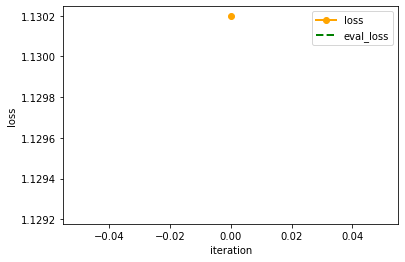

In [16]:
import google.datalab.bigquery as bq
df = bq.Query("SELECT * FROM ML.TRAINING_INFO(MODEL demo.babyweight_model_asis)").execute().result().to_dataframe()
# plot both lines in same graph
import matplotlib.pyplot as plt
plt.plot( 'iteration', 'loss', data = df, marker = 'o', color = 'orange', linewidth = 2)
plt.plot( 'iteration', 'eval_loss', data = df, marker = '', color = 'green', linewidth = 2, linestyle = 'dashed')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend();

As you can see, the training loss and evaluation loss are essentially identical. We do not seem to be overfitting.

## Make a Prediction with BQML using the Model

With a trained model, it is now possible to make a prediction on the values. The only difference from the second query above is the reference to the model. The data has been limited (`LIMIT 100`) to reduce amount of data returned.

When the `ml.predict` function is leveraged, output prediction column name for the model is `predicted_<label_column_name>`.

In [17]:
%%bigquery
SELECT
  *
FROM
  ml.PREDICT(MODEL demo.babyweight_model_asis,
      (SELECT
        weight_pounds,
        CAST(is_male AS STRING) AS is_male,
        mother_age,
        CAST(plurality AS STRING) AS plurality,
        gestation_weeks
      FROM
        publicdata.samples.natality
      WHERE
        year > 2000
        AND gestation_weeks > 0
        AND mother_age > 0
        AND plurality > 0
        AND weight_pounds > 0
    ))
LIMIT 100

,predicted_weight_pounds,weight_pounds,is_male,mother_age,plurality,gestation_weeks
0,7.088477,7.063611,true,32,1,37
1,4.034388,4.687028,true,30,3,33
2,7.350467,7.561856,true,20,1,39
3,7.066734,7.561856,true,31,1,37
4,7.872832,7.312733,true,32,1,40
...,...,...,...,...,...,...
95,5.520307,4.312242,true,20,1,32
96,7.175987,8.437091,true,24,1,38
97,7.241215,7.687519,true,27,1,38
98,8.187265,7.634608,false,23,1,43


# More advanced...

In the original example, we were taking into account the idea that if no ultrasound has been performed, some of the features (e.g. is_male) will not be known. Therefore, we augmented the dataset with such masked features and trained a single model to deal with both these scenarios.

In addition, during data exploration, we learned that the data size set for mothers older than 45 was quite sparse, so we will discretize the mother age.

In [18]:
%%bigquery
SELECT
    weight_pounds,
    CAST(is_male AS STRING) AS is_male,
    IF(mother_age < 18, 'LOW',
         IF(mother_age > 45, 'HIGH',
            CAST(mother_age AS STRING))) AS mother_age,
    CAST(plurality AS STRING) AS plurality,
    CAST(gestation_weeks AS STRING) AS gestation_weeks,
    FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
  FROM
    publicdata.samples.natality
  WHERE
    year > 2000
    AND gestation_weeks > 0
    AND mother_age > 0
    AND plurality > 0
    AND weight_pounds > 0
LIMIT 25

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,7.063611,true,32,1,37,7108882242435606404
1,4.687028,true,30,3,33,-7170969733900686954
2,7.561856,true,20,1,39,6392072535155213407
3,7.561856,true,31,1,37,-2126480030009879160
4,7.312733,true,32,1,40,3408502330831153141
5,7.627994,false,30,1,40,-2126480030009879160
6,7.251004,true,33,1,37,3408502330831153141
7,7.500126,false,23,1,39,5896567601480310696
8,7.125340,false,33,1,39,-7146494315947640619
9,7.749249,true,31,1,39,-7146494315947640619


On the same dataset, will also suppose that it is unknown whether the child is male or female (on the same dataset) to simulate that an ultrasound was not been performed.

In [19]:
%%bigquery
SELECT
    weight_pounds,
    'Unknown' AS is_male,
    IF(mother_age < 18, 'LOW',
         IF(mother_age > 45, 'HIGH',
            CAST(mother_age AS STRING))) AS mother_age,
    IF(plurality > 1, 'Multiple', 'Single') AS plurality,
    CAST(gestation_weeks AS STRING) AS gestation_weeks,
    FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
  FROM
    publicdata.samples.natality
  WHERE
    year > 2000
    AND gestation_weeks > 0
    AND mother_age > 0
    AND plurality > 0
    AND weight_pounds > 0
LIMIT 25

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,6.686620,Unknown,18,Single,43,8904940584331855459
1,9.360828,Unknown,32,Single,41,1088037545023002395
2,8.437091,Unknown,30,Single,39,5896567601480310696
3,6.124442,Unknown,24,Single,40,-6244544205302024223
4,7.125340,Unknown,26,Single,41,-8029892925374153452
5,6.944561,Unknown,31,Single,40,-2126480030009879160
6,6.999677,Unknown,23,Single,40,1088037545023002395
7,9.374055,Unknown,34,Single,40,-1525201076796226340
8,8.373157,Unknown,33,Single,40,3408502330831153141
9,7.187070,Unknown,23,Single,40,-1403073183891835564


Bringing these two separate data sets together, there is now a dataset for male or female children determined with ultrasound or unknown if without. 

In [20]:
%%bigquery
WITH with_ultrasound AS (
  SELECT
    weight_pounds,
    CAST(is_male AS STRING) AS is_male,
    IF(mother_age < 18, 'LOW',
         IF(mother_age > 45, 'HIGH',
            CAST(mother_age AS STRING))) AS mother_age,
    CAST(plurality AS STRING) AS plurality,
    CAST(gestation_weeks AS STRING) AS gestation_weeks,
    FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
  FROM
    publicdata.samples.natality
  WHERE
    year > 2000
    AND gestation_weeks > 0
    AND mother_age > 0
    AND plurality > 0
    AND weight_pounds > 0
),

without_ultrasound AS (
  SELECT
    weight_pounds,
    'Unknown' AS is_male,
    IF(mother_age < 18, 'LOW',
         IF(mother_age > 45, 'HIGH',
            CAST(mother_age AS STRING))) AS mother_age,
    IF(plurality > 1, 'Multiple', 'Single') AS plurality,
    CAST(gestation_weeks AS STRING) AS gestation_weeks,
    FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
  FROM
    publicdata.samples.natality
  WHERE
    year > 2000
    AND gestation_weeks > 0
    AND mother_age > 0
    AND plurality > 0
    AND weight_pounds > 0
),

preprocessed AS (
  SELECT * from with_ultrasound
  UNION ALL
  SELECT * from without_ultrasound
)

SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks
FROM
    preprocessed
WHERE
  ABS(MOD(hashmonth, 4)) < 3
LIMIT 25

,weight_pounds,is_male,mother_age,plurality,gestation_weeks
0,8.818490,Unknown,LOW,Single,42
1,5.948072,Unknown,38,Single,38
2,8.838332,Unknown,27,Single,39
3,7.063611,Unknown,18,Single,40
4,7.500126,Unknown,31,Single,44
5,6.250105,Unknown,23,Single,41
6,6.117828,Unknown,24,Single,36
7,9.124933,Unknown,26,Single,40
8,8.062305,Unknown,23,Single,38
9,8.027031,Unknown,28,Single,39


## Create a new model

With a data set which has been feature engineered, it is ready to create model with the `CREATE or REPLACE MODEL` statement

This will take **5-10 minutes** and will show **Done** when complete.

In [21]:
%%bigquery
CREATE or REPLACE MODEL demo.babyweight_model_fc
OPTIONS
  (model_type = 'linear_reg', labels = ['weight_pounds']) AS
  
WITH with_ultrasound AS (
  SELECT
    weight_pounds,
    CAST(is_male AS STRING) AS is_male,
    IF(mother_age < 18, 'LOW',
         IF(mother_age > 45, 'HIGH',
            CAST(mother_age AS STRING))) AS mother_age,
    CAST(plurality AS STRING) AS plurality,
    CAST(gestation_weeks AS STRING) AS gestation_weeks,
    FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
  FROM
    publicdata.samples.natality
  WHERE
    year > 2000
    AND gestation_weeks > 0
    AND mother_age > 0
    AND plurality > 0
    AND weight_pounds > 0
),

without_ultrasound AS (
  SELECT
    weight_pounds,
    'Unknown' AS is_male,
    IF(mother_age < 18, 'LOW',
         IF(mother_age > 45, 'HIGH',
            CAST(mother_age AS STRING))) AS mother_age,
    IF(plurality > 1, 'Multiple', 'Single') AS plurality,
    CAST(gestation_weeks AS STRING) AS gestation_weeks,
    FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
  FROM
    publicdata.samples.natality
  WHERE
    year > 2000
    AND gestation_weeks > 0
    AND mother_age > 0
    AND plurality > 0
    AND weight_pounds > 0
),

preprocessed AS (
  SELECT * from with_ultrasound
  UNION ALL
  SELECT * from without_ultrasound
)

SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks
FROM
    preprocessed
WHERE
  ABS(MOD(hashmonth, 4)) < 3

""


## Training Statistics

While the new model is training, review the training statistics in the BigQuery UI to see the below model training: https://bigquery.cloud.google.com/

The training details may also be viewed after the training completes from this notebook.

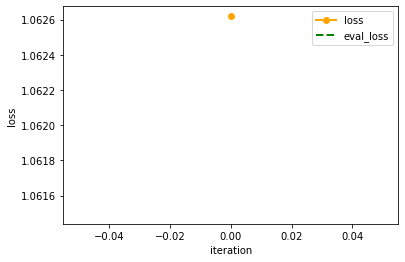

In [22]:
import google.datalab.bigquery as bq
df = bq.Query("SELECT * FROM ML.TRAINING_INFO(MODEL demo.babyweight_model_fc)").execute().result().to_dataframe()
# plot both lines in same graph
import matplotlib.pyplot as plt
plt.plot( 'iteration', 'loss', data = df, marker = 'o', color = 'orange', linewidth = 2)
plt.plot( 'iteration', 'eval_loss', data = df, marker = '', color = 'green', linewidth = 2, linestyle = 'dashed')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend();

## Make a prediction with the new model



Perhaps it is of interest to make a prediction of the baby's weight given a number of other factors: Male, Mother is 28 years old, Mother will only have one child, and the baby was born after 38 weeks of pregnancy.

To make this prediction, these values will be passed into the SELECT statement.

In [23]:
%%bigquery
SELECT
  *
FROM
  ml.PREDICT(MODEL demo.babyweight_model_fc,
      (SELECT
          'True' AS is_male,
          '28' AS mother_age,
          '1' AS plurality,
          '38' AS gestation_weeks
    ))

,predicted_weight_pounds,is_male,mother_age,plurality,gestation_weeks
0,-31076.707789,True,28,1,38
